In [38]:
import pandas as pd
import math
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky, wcsutils
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from tqdm import tqdm

In [2]:
amf = pd.read_csv('../data/dr9_main_complete.csv', header=None)
amf.columns = ['amf_no','amf_ra','amf_dec','amf_z','amf_lk','amf_rh','amf_r200','amf_rc','amf_c','amf_str_rh','bax_id','mcxc_id','red_id','whl_id']

c = SkyCoord(amf['amf_ra'],amf['amf_dec'],frame='icrs',unit='deg')
amf['glat'] = c.galactic.b.degree
amf['glon'] = c.galactic.l.degree

amf_whl = amf[(amf.whl_id!='-9999')]

In [3]:
hdul = fits.open("../data/datafile2.fits")
data = hdul[1].data
dcl = pd.DataFrame({'RA':data['RA_PEAK'],
                    'dec':data['DEC_PEAK']})
c = SkyCoord(dcl['RA'],dcl['dec'],frame='icrs',unit='deg')
dcl['glat'] = c.galactic.b.degree
dcl['glon'] = c.galactic.l.degree

KeyboardInterrupt: 

In [42]:
wh22 = pd.read_csv('cluster_DESunWISE.dat', sep='\s+', header=None, usecols=[3,4,5,11])
wh22.columns = ['ra','dec','z','m']
c = SkyCoord(wh22['ra'],wh22['dec'],frame='icrs',unit='deg')
wh22['glat'] = c.galactic.b.degree
wh22['glon'] = c.galactic.l.degree

In [46]:
wh22.to_csv('wh22.csv')

In [45]:
wh22[wh22.m>1]

,ra,dec,z,m,glat,glon
1,0.00555,-64.16639,0.6423,1.62,-52.047056,312.001004
5,0.01274,-3.54574,0.6056,1.92,-63.412207,93.207379
6,0.01592,-1.03153,0.7327,1.20,-61.138542,95.516099
10,0.01797,-48.57829,0.3503,1.11,-66.349538,324.434813
13,0.02301,-46.45272,1.0846,1.16,-68.176853,327.246557
...,...,...,...,...,...,...
151237,359.98636,-60.21932,0.7862,1.04,-55.760566,314.274236
151238,359.98685,-65.80522,1.1063,1.21,-50.490097,311.183225
151239,359.98911,-6.40920,1.0678,2.97,-65.938253,90.050298
151242,359.99503,-37.71075,0.6743,1.99,-74.866209,345.359827


In [37]:
len(wh22[wh22.m>1])/len(wh22)

0.4604810769352834

In [4]:
amf_whl_dcl = pd.DataFrame()
amf_whl_dcl = pd.DataFrame(data=amf_whl_dcl, columns=amf_whl.columns)

In [10]:
amf_whl_dcl = amf_whl_dcl.iloc[0:0]

for i in tqdm(range(amf_whl.shape[0])):
    matches = dcl.loc[(dcl['glat'].sub(amf_whl.iloc[i]['glat']).abs()<1) & (dcl['glon'].sub(amf_whl.iloc[i]['glon']).abs()<1)]
    if len(matches)!=0:     
        amf_whl_dcl.loc[len(amf_whl_dcl)] = amf_whl.iloc[i]
        
amf_whl_dcl = amf_whl_dcl.reset_index()

100%|██████████| 31950/31950 [12:45<00:00, 41.76it/s]


In [7]:
amf_whl_dcl.to_csv('awd.csv')

In [10]:
hdul = fits.open("../../overlaps/masks/DR5_cluster-catalog_v1.1.fits")
data = hdul[1].data

adv = pd.DataFrame({'name':data['name'].byteswap().newbyteorder(),
                    'RA':data['RADeg'].byteswap().newbyteorder(),
                    'dec':data['decDeg'].byteswap().newbyteorder(),
                    'SNR':data['SNR'].byteswap().newbyteorder(),
                    'redshift':data['redshift'].byteswap().newbyteorder(),
                    'RM':data['RM'].byteswap().newbyteorder()})

c = SkyCoord(adv['RA'],adv['dec'],frame='icrs',unit='deg')
adv['glat'] = c.galactic.b.degree
adv['glon'] = c.galactic.l.degree

In [48]:
plsz2 = pd.read_csv('../data/planck_sz2.csv',header=None)
plsz2.columns = ['pl_no','pl_name','pl_glon','pl_glat','pl_ra','pl_dec','pl_poserr','pl_sn',\
                   'pl_pipe','pl_pipedet','pl_pccs2','pl_psz','pl_irflag','pl_qneural','pl_y5r500',\
                   'pl_y5r500err','pl_valid','pl_zid','pl_z','pl_msz','pl_mszerrup','pl_mszerrlow',\
                   'pl_mcxc','pl_red','pl_act','pl_spt','pl_wise','pl_ami','pl_cosmo','pl_comment']

In [11]:
ard_not_adv = pd.DataFrame(data=amf_whl_dcl, columns=amf_whl_dcl.columns)

In [22]:
ard_not_adv = ard_not_adv.iloc[0:0]

for i in tqdm(range(amf_whl_dcl.shape[0])):
    matches = plsz2.loc[(plsz2['pl_glat'].sub(amf_whl_dcl.iloc[i]['glat']).abs()<1) & (plsz2['pl_glon'].sub(amf_whl_dcl.iloc[i]['glon']).abs()<1)]
    if len(matches)==0:     
        ard_not_adv.loc[len(ard_not_adv)] = amf_whl_dcl.iloc[i]
    else:
        print(round(amf_whl_dcl.iloc[i]['glon'],2),round(amf_whl_dcl.iloc[i]['glat'],2))
        print(matches[['pl_glon','pl_glat']])
        print("\n")
        
ard_not_adv = ard_not_adv.reset_index()

  0%|          | 8/31535 [00:00<07:31, 69.82it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  0%|          | 16/31535 [00:00<07:10, 73.22it/s]

55.6 31.85
       pl_glon    pl_glat
222  55.592973  31.859891


313.37 61.13
         pl_glon    pl_glat
1477  313.330748  61.130877


72.6 41.43
       pl_glon    pl_glat
306  72.626671  41.466182


92.18 -35.42
       pl_glon    pl_glat
418  92.465163 -35.223969


116.52 -44.5
        pl_glon    pl_glat
563  115.584419 -44.563108
570  116.500521 -44.476971


107.1 65.31
        pl_glon    pl_glat
518  107.102389  65.322512


283.5 77.4
         pl_glon    pl_glat
1318  283.266445  77.374803


100.21 -29.65
        pl_glon    pl_glat
481  100.226184 -29.640822


166.09 43.39
        pl_glon    pl_glat
790  165.685561  44.018045
793  166.093691  43.381717


195.61 44.09
        pl_glon    pl_glat
893  195.604283  44.066448


74.07 -54.64
       pl_glon    pl_glat
313  73.827112 -54.921574
315  74.089225 -54.688278


54.94 -33.38
       pl_glon    pl_glat
220  54.956314 -33.391372


92.65 73.44
      pl_glon    pl_glat
421  92.71962  73.460181


81.07 -50.91
       pl_glon    pl_glat
3

/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  0%|          | 24/31535 [00:00<07:17, 72.03it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  0%|          | 32/31535 [00:00<07:08, 73.56it/s]

20.14 37.53
      pl_glon    pl_glat
63  20.084824  37.474445
66  20.669879  37.996416
68  21.082242  38.003749


187.58 22.0
        pl_glon    pl_glat
866  187.533226  21.923607


187.01 38.66
        pl_glon    pl_glat
865  186.990102  38.658411


113.93 -37.03
       pl_glon    pl_glat
550  113.91145 -37.016998


73.83 -54.92
       pl_glon    pl_glat
313  73.827112 -54.921574
315  74.089225 -54.688278


161.91 -48.18
        pl_glon    pl_glat
771  161.940769 -48.175337


72.66 -43.26
       pl_glon    pl_glat
302  71.674386 -42.760518
305  72.599699 -43.259436


168.45 69.76
        pl_glon    pl_glat
804  168.336578  69.737555


124.22 -36.48
        pl_glon    pl_glat
609  124.204739 -36.482096


254.76 82.31
         pl_glon    pl_glat
1172  254.922467  82.317932


173.0 -53.56
       pl_glon    pl_glat
817  172.98962 -53.554334


231.56 60.01
         pl_glon    pl_glat
1049  231.568166  60.039224


204.17 15.44
        pl_glon    pl_glat
922  204.249827  14.517421
923  204.7

/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  0%|          | 40/31535 [00:00<07:37, 68.85it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  0%|          | 48/31535 [00:00<07:30, 69.84it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is tr

229.73 77.99
         pl_glon    pl_glat
1039  229.747503  77.963775


89.82 -39.52
       pl_glon   pl_glat
403  89.814201 -39.56629


50.08 -27.3
       pl_glon    pl_glat
202  50.067812 -27.322997


91.42 -51.01
       pl_glon    pl_glat
410  91.408972 -51.013618


133.45 69.02
        pl_glon    pl_glat
652  133.600721  69.046192


180.88 31.01
        pl_glon    pl_glat
840  180.882547  31.045073


84.15 -35.4
       pl_glon    pl_glat
362  84.138587 -35.414117


74.72 -24.57
       pl_glon    pl_glat
317  74.759064 -24.599018


340.46 60.62
         pl_glon    pl_glat
1588  340.366037  60.582555


117.53 -53.26
        pl_glon    pl_glat
572  116.955471 -53.551372
574  117.380708 -52.475151


109.95 -70.27
        pl_glon   pl_glat
535  109.993995 -70.28394


83.27 -31.04
       pl_glon    pl_glat
357  83.299233 -31.036349


231.77 31.49
         pl_glon    pl_glat
1052  231.794053  31.488174


0.11 78.07
    pl_glon    pl_glat
1  0.138058  78.042114


121.17 49.62
        pl_glo

/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  0%|          | 65/31535 [00:00<07:25, 70.57it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

86.83 -61.19
       pl_glon    pl_glat
387  86.731859 -61.165378


123.66 67.26
        pl_glon    pl_glat
605  123.660657  67.254014


130.27 -62.63
        pl_glon    pl_glat
641  130.214546 -62.608176


134.69 53.4
        pl_glon    pl_glat
656  134.594547  53.385005
660  135.063183  54.395842


155.84 70.39
        pl_glon   pl_glat
751  155.806683  70.40959


213.37 50.93
        pl_glon    pl_glat
958  212.803063  50.637425
962  213.305483  50.991205


142.17 -53.26
       pl_glon    pl_glat
690  142.18414 -53.270864


44.61 -20.49
       pl_glon    pl_glat
162  44.589076 -20.464256




/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  0%|          | 73/31535 [00:01<07:30, 69.90it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  0%|          | 81/31535 [00:01<07:18, 71.71it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is tr

55.95 -34.89
       pl_glon    pl_glat
224  55.954198 -34.896199


323.33 63.66
         pl_glon    pl_glat
1519  323.301646  63.668663


100.19 -30.38
        pl_glon    pl_glat
481  100.226184 -29.640822


54.98 53.4
       pl_glon    pl_glat
219  54.851313  54.301135
221  54.997972  53.415247


150.54 58.32
        pl_glon    pl_glat
730  150.565701  58.327959


125.67 53.85
        pl_glon    pl_glat
618  125.711546  53.865421


114.26 64.91
        pl_glon    pl_glat
552  114.311109  64.898128


126.77 -33.06
        pl_glon    pl_glat
621  126.208017 -33.174265


195.38 -29.1
       pl_glon    pl_glat
892  195.39323 -29.088282


218.79 35.54
        pl_glon    pl_glat
983  218.818696  35.510379


126.58 -37.73
        pl_glon   pl_glat
625  126.611982 -37.63472


77.9 -26.62
       pl_glon   pl_glat
331  77.902321 -26.63026


59.8

  0%|          | 89/31535 [00:01<07:17, 71.88it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

 -39.12
       pl_glon    pl_glat
250  59.818196 -39.096231


215.58 22.61
        pl_glon    pl_glat
971  215.611669  22.612152


209.6 43.33
        pl_glon    pl_glat
941  209.533949  43.326724


68.69 -46.55
       pl_glon    pl_glat
291  68.613376 -46.606103


203.17 20.86
       pl_glon    pl_glat
917  203.18286  20.843817


96.86 52.49
       pl_glon    pl_glat
449  96.839683  52.491169
454  97.523203  51.706841


87.02 -57.36
       pl_glon    pl_glat
390  87.037265 -57.374117


14.03 38.39
     pl_glon   pl_glat
45  14.09783  38.38787


198.47 46.02
        pl_glon    pl_glat
898  198.466965  46.016932

/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  0%|          | 105/31535 [00:01<07:27, 70.18it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr




107.69 -58.31
        pl_glon   pl_glat
522  107.661599 -58.32758


126.26 -33.23
        pl_glon    pl_glat
621  126.208017 -33.174265


123.0 -35.52
        pl_glon    pl_glat
601  123.001352 -35.525651


138.31 -39.83
        pl_glon    pl_glat
677  138.320226 -39.821206


187.75 20.63
        pl_glon    pl_glat
867  187.740375  20.665526


92.24 -55.74
       pl_glon    pl_glat
416  92.303464 -55.758466


59.77 -46.25
       pl_glon    pl_glat
248  59.720648 -46.210861




/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  0%|          | 120/31535 [00:01<07:52, 66.51it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

53.63 -41.81
       pl_glon    pl_glat
214  53.633436 -41.841365


195.23 29.31
        pl_glon    pl_glat
891  195.241862  29.348577


81.33 -68.49
       pl_glon    pl_glat
348  81.310033 -68.563841


67.22 67.46
       pl_glon    pl_glat
279  66.683499  68.449007
282  67.179154  67.463287


78.33 -47.18
       pl_glon    pl_glat
333  78.366009 -47.225618


220.81 42.26
        pl_glon    pl_glat
991  220.837825  42.202304


286.36 64.04
         pl_glon    pl_glat
1335  286.394388  64.064579




/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  0%|          | 134/31535 [00:01<07:46, 67.29it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

21.12 37.96
      pl_glon    pl_glat
66  20.669879  37.996416
68  21.082242  38.003749


165.6 43.94
        pl_glon    pl_glat
790  165.685561  44.018045
793  166.093691  43.381717


68.35 81.8
       pl_glon    pl_glat
289  68.367989  81.812048


225.85 41.81
        pl_glon    pl_glat
1014  225.84793  41.841415


166.66 42.14
        pl_glon    pl_glat
797  166.622133  42.132685


101.57 -29.96
        pl_glon    pl_glat
489  101.521942 -29.985687


57.26 -45.35
       pl_glon    pl_glat
233  57.254167 -45.349749


58.53 -49.41
       pl_glon    pl_glat
243  58.815797 -49.685514


53.5 -36.28
       pl_glon    pl_glat
211  53.440287 -36.256074


136.94 -53.28
        pl_glon    pl_glat
670  136.910989 -53.218056


176.29 -52.59
       pl_glon    pl_glat
827  176.25605 -52.572795


112.4 -32.88
        pl_glon    pl_glat
542  112.353361 -32.867347




  0%|          | 150/31535 [00:02<07:25, 70.46it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  1%|          | 158/31535 [00:02<07:44, 67.51it/s]

221.32 43.2
        pl_glon    pl_glat
991  220.837825  42.202304


163.64 53.59
        pl_glon    pl_glat
777  163.698789  53.521466


167.65 -65.59
        pl_glon    pl_glat
801  167.667661 -65.593571


127.3 -29.67
       pl_glon    pl_glat
632  127.50723 -30.523297


104.7 -54.55
        pl_glon    pl_glat
501  104.719352 -54.547704
503  104.986476 -54.795844




  1%|          | 165/31535 [00:02<08:02, 65.04it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

89.02 -40.51
       pl_glon   pl_glat
403  89.814201 -39.56629


62.51 -46.43
       pl_glon    pl_glat
258  62.442855 -46.430333


219.87 22.78
        pl_glon    pl_glat
986  219.884130  22.838087
988  220.114561  22.914191


57.68 51.58
       pl_glon    pl_glat
235  57.733062  51.580168
236  57.783082  52.328208


44.4 48.68
       pl_glon    pl_glat
159  44.203659  48.669897


190.65 66.45
        pl_glon    pl_glat
875  190.618908  66.462421


230.75 27.73
         pl_glon    pl_glat
1045  230.738625  27.708115




/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  1%|          | 179/31535 [00:02<07:55, 65.99it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

183.3 35.0
        pl_glon    pl_glat
847  183.306774  34.988625


228.49 34.97
         pl_glon    pl_glat
1034  228.502684  34.955759


301.11 60.08
         pl_glon    pl_glat
1417  301.117394  60.058681


213.31 23.21
        pl_glon    pl_glat
965  214.086552  23.153171


217.11 40.17
        pl_glon   pl_glat
978  217.091088  40.15889


196.25 43.08
        pl_glon    pl_glat
893  195.604283  44.066448




/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  1%|          | 200/31535 [00:02<07:55, 65.94it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

122.47 -38.41
        pl_glon  pl_glat
598  122.478112 -38.4177


216.25 23.22
        pl_glon    pl_glat
971  215.611669  22.612152


171.12 38.5
        pl_glon    pl_glat
808  170.988246  39.455803


91.12 -39.11
       pl_glon    pl_glat
409  91.274652 -38.620167


101.4 32.43
        pl_glon    pl_glat
488  101.369249  32.392737


122.81 -36.56
       pl_glon    pl_glat
600  122.89273 -36.820782


204.11 16.49
        pl_glon    pl_glat
921  204.109220  16.511543
923  204.739988  15.888500




/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  1%|          | 215/31535 [00:03<07:53, 66.20it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

92.25 -66.04
       pl_glon    pl_glat
415  92.160509 -66.016063


289.07 72.16
         pl_glon    pl_glat
1357  289.133464  72.197015


127.49 -69.79
        pl_glon    pl_glat
633  127.712366 -69.559967


52.36 -31.97
       pl_glon    pl_glat
209  52.357157 -31.987998


74.91 -24.37
       pl_glon    pl_glat
317  74.759064 -24.599018


104.3 -49.02
       pl_glon    pl_glat
498  104.30442 -48.994882


198.18 46.36
        pl_glon    pl_glat
898  198.466965  46.016932


172.19 -53.34
       pl_glon    pl_glat
817  172.98962 -53.554334


68.51 -39.13
       pl_glon    pl_glat
290  68.495565 -39.128978




/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  1%|          | 229/31535 [00:03<08:02, 64.91it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  1%|          | 237/31535 [00:03<07:36, 68.58it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is 

126.75 -33.35
        pl_glon    pl_glat
621  126.208017 -33.174265


209.8 16.23
        pl_glon    pl_glat
947  210.224002  15.567146
950  210.648539  17.097156


154.14 40.19
        pl_glon    pl_glat
747  154.137058  40.199771


144.26 -34.74
        pl_glon    pl_glat
704  144.842077 -35.164908


115.69 -27.59
        pl_glon    pl_glat
565  115.674841 -27.576461


218.31 71.26
       pl_glon    pl_glat
982  218.59491  71.314555


181.47 -44.76
       pl_glon    pl_glat
842  181.44847 -44.762938


71.47 59.54
       pl_glon    pl_glat
300  71.390134  59.549224


100.35 -29.1
        pl_glon    pl_glat
481  100.226184 -29.640822




  1%|          | 252/31535 [00:03<07:37, 68.39it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

91.21 -53.14
       pl_glon    pl_glat
408  90.668234 -52.346246


233.68 36.13
         pl_glon    pl_glat
1062  233.688038  36.147869


209.82 16.24
        pl_glon    pl_glat
947  210.224002  15.567146
950  210.648539  17.097156


225.48 29.4
         pl_glon    pl_glat
1011  225.488696  29.411926


227.22 54.77
         pl_glon    pl_glat
1021  227.211843  54.796788
1025  227.611982  54.879878


106.66 66.73
        pl_glon    pl_glat
516  106.613963  66.717883


89.47 -58.12
       pl_glon    pl_glat
401  89.468868 -58.097201


204.06 16.48
        pl_glon    pl_glat
921  204.109220  16.511543
923  204.739988  15.888500


77.15 -65.46
       pl_glon    pl_glat
328  77.203522 -65.459174




/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  1%|          | 267/31535 [00:03<07:23, 70.53it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

90.97 -39.5
       pl_glon    pl_glat
409  91.274652 -38.620167


201.57 30.61
        pl_glon    pl_glat
913  201.541375  30.628433


90.64 -52.36
       pl_glon    pl_glat
408  90.668234 -52.346246


111.73 70.37
        pl_glon    pl_glat
540  111.756136  70.375137


318.77 58.55
        pl_glon    pl_glat
1503  318.62091  58.559669


185.22 -53.66
        pl_glon    pl_glat
855  185.169129 -53.634407


42.84 56.63
       pl_glon    pl_glat
155  42.811728  56.610086


164.63 46.37
        pl_glon    pl_glat
783  164.652946  46.379754


116.98 -53.54
        pl_glon    pl_glat
572  116.955471 -53.551372




/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  1%|          | 284/31535 [00:04<07:11, 72.41it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

81.78 70.15
       pl_glon    pl_glat
351  81.728741  70.154137


182.55 55.86
        pl_glon    pl_glat
846  182.598737  55.836955


94.55 -69.67
       pl_glon    pl_glat
433  94.463784 -69.658404


222.56 20.56
        pl_glon    pl_glat
993  222.525104  20.584364


127.2 -34.77
        pl_glon    pl_glat
631  127.443804 -34.746004


355.03 55.33
         pl_glon    pl_glat
1634  355.074298  55.320074
1636  355.508611  54.724153


143.24 65.23
        pl_glon    pl_glat
695  143.261537  65.248605


91.04 -27.85
       pl_glon    pl_glat
412  91.795448 -27.002925


224.06 69.33
         pl_glon    pl_glat
1001  224.001238  69.332391


195.01 54.12
        pl_glon    pl_glat
889  194.980251  54.127206


231.76 30.8
         pl_glon    pl_glat
1052  231.794053  31.488174

/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  1%|          | 308/31535 [00:04<07:13, 72.03it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  1%|          | 316/31535 [00:04<07:18, 71.24it/s]




127.47 -34.76
        pl_glon    pl_glat
631  127.443804 -34.746004


186.37 37.27
       pl_glon    pl_glat
861  186.37697  37.269775


60.28 -46.52
       pl_glon    pl_glat
248  59.720648 -46.210861


81.06 -46.97
       pl_glon    pl_glat
343  80.653421 -46.819131


151.17 48.26
        pl_glon    pl_glat
728  150.245310  48.723500
733  151.190827  48.271461




/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  1%|          | 324/31535 [00:04<07:17, 71.32it/s]/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

59.06 -39.17
       pl_glon    pl_glat
250  59.818196 -39.096231


100.45 -38.39
        pl_glon    pl_glat
485  100.458644 -38.428684


172.62 35.14
        pl_glon    pl_glat
814  172.633128  35.152194


157.68 78.05
        pl_glon    pl_glat
759  157.631996  78.026633


226.1 30.06
         pl_glon    pl_glat
1011  225.488696  29.411926


80.4 -33.23
       pl_glon    pl_glat
340  80.411134 -33.242035


37.48 71.51
       pl_glon    pl_glat
133  37.481237  71.525269




/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
  1%|          | 348/31535 [00:05<07:38, 67.98it/s]

126.02 -49.64
        pl_glon    pl_glat
620  126.073066 -49.556256


137.3 -28.07
        pl_glon    pl_glat
675  137.744034 -27.088707


114.65 -60.04
       pl_glon    pl_glat
553  114.39786 -60.167978


180.41 76.71
        pl_glon    pl_glat
838  180.604092  76.650536


223.5 26.85
        pl_glon    pl_glat
999  223.478676  26.851365


66.62 68.4
       pl_glon    pl_glat
279  66.683499  68.449007
282  67.179154  67.463287


89.1 -38.83
       pl_glon   pl_glat
403  89.814201 -39.56629


170.29 33.87
        pl_glon    pl_glat
805  169.623792  33.842124




  1%|          | 370/31535 [00:05<07:38, 67.94it/s]

48.89 -25.58
       pl_glon    pl_glat
195  48.911019 -25.551706
201  49.803806 -25.168287


49.26 65.06
       pl_glon    pl_glat
197  49.189222  65.057395


127.52 -30.54
       pl_glon    pl_glat
632  127.50723 -30.523297


122.92 -36.79
       pl_glon    pl_glat
600  122.89273 -36.820782


273.68 63.32
         pl_glon    pl_glat
1273  273.593209  63.277283




  1%|          | 391/31535 [00:05<07:53, 65.71it/s]

55.62 31.37
       pl_glon    pl_glat
222  55.592973  31.859891


0.15 45.21
    pl_glon    pl_glat
0  0.040543  45.135175


153.06 -58.23
        pl_glon   pl_glat
741  153.007369 -58.26545


227.1 48.46
        pl_glon    pl_glat
1020  226.75183  48.957417


153.7 41.0
        pl_glon    pl_glat
747  154.137058  40.199771


46.92 56.48
       pl_glon   pl_glat
182  46.887289  56.48362




  1%|▏         | 406/31535 [00:05<07:45, 66.82it/s]

84.71 42.3
       pl_glon    pl_glat
369  84.691344  42.284598


123.2 -38.47
        pl_glon  pl_glat
598  122.478112 -38.4177


44.91 67.45
      pl_glon    pl_glat
167  45.13864  67.787385




  1%|▏         | 420/31535 [00:06<08:03, 64.32it/s]

7.45 50.32
     pl_glon    pl_glat
20  6.498554  50.563311
24  6.844326  50.693866


87.13 -41.74
      pl_glon    pl_glat
392  87.25354 -41.861543


216.67 47.01
        pl_glon    pl_glat
975  216.629048  47.008208


107.65 -39.84
        pl_glon    pl_glat
519  107.111758 -39.506159
523  107.678875 -39.786198


114.39 -60.17
       pl_glon    pl_glat
553  114.39786 -60.167978


67.77 -38.43
       pl_glon    pl_glat
290  68.495565 -39.128978




  1%|▏         | 436/31535 [00:06<07:33, 68.64it/s]

48.19 57.09
       pl_glon    pl_glat
189  48.107457  57.164621


238.7 63.23
         pl_glon    pl_glat
1075  238.695632  63.263526


62.39 -45.55
       pl_glon    pl_glat
258  62.442855 -46.430333


145.82 41.57
        pl_glon    pl_glat
712  146.130707  40.971273
715  146.821223  40.976483


228.85 34.52
         pl_glon    pl_glat
1034  228.502684  34.955759


83.6 -35.35
       pl_glon    pl_glat
362  84.138587 -35.414117


227.59 54.88
         pl_glon    pl_glat
1021  227.211843  54.796788
1025  227.611982  54.879878
1030  228.295981  55.086546


230.44 71.52
         pl_glon    pl_glat
1044  230.488504  71.514534




  1%|▏         | 461/31535 [00:06<07:11, 71.95it/s]

39.59 75.0
       pl_glon    pl_glat
144  40.038215  74.954301


2.42 69.7
    pl_glon    pl_glat
6  2.427468  69.648458


187.72 20.72
        pl_glon    pl_glat
867  187.740375  20.665526


343.18 83.17
         pl_glon    pl_glat
1604  343.335806  83.198269


93.93 34.96
       pl_glon    pl_glat
426  93.929596  34.929707


285.53 72.74
         pl_glon    pl_glat
1328  285.635888  72.752883


113.29 -29.7
       pl_glon    pl_glat
548  113.29309 -29.695237


60.11 64.5
       pl_glon    pl_glat
254  60.166232  64.500308


91.18 -50.67
       pl_glon    pl_glat
410  91.408972 -51.013618


89.04

  2%|▏         | 477/31535 [00:06<07:19, 70.61it/s]

 -40.21
       pl_glon   pl_glat
403  89.814201 -39.56629


49.79 -25.18
       pl_glon    pl_glat
195  48.911019 -25.551706
201  49.803806 -25.168287


28.91 60.14
       pl_glon    pl_glat
100  28.892508  60.136299


155.33 -60.07
       pl_glon    pl_glat
750  155.46427 -60.154651


81.68 -50.48
       pl_glon    pl_glat
345  81.001659 -50.930361


92.78 -35.15
       pl_glon    pl_glat
418  92.465163 -35.223969


85.71 -24.33
       pl_glon    pl_glat
382  86.432285 -24.958023




  2%|▏         | 493/31535 [00:07<07:12, 71.85it/s]

109.94 52.86
        pl_glon    pl_glat
534  109.970361  52.847535


114.16 58.94
        pl_glon    pl_glat
551  114.146326  58.964778


72.19 -41.68
       pl_glon    pl_glat
308  72.801952 -41.127219


67.43 -21.22
       pl_glon    pl_glat
283  67.216301 -20.492073




  2%|▏         | 516/31535 [00:07<07:31, 68.69it/s]

56.08 36.19
      pl_glon    pl_glat
228  56.77371  36.320455


3.98 42.2
     pl_glon    pl_glat
13  4.046388  42.236958


72.2 -41.68
       pl_glon    pl_glat
308  72.801952 -41.127219


152.36 81.28
        pl_glon    pl_glat
737  152.334219  81.280099


81.2 -41.95
      pl_glon    pl_glat
347  81.22884 -41.952314


50.13 -27.54
       pl_glon    pl_glat
202  50.067812 -27.322997




  2%|▏         | 532/31535 [00:07<07:34, 68.21it/s]

95.69 44.25
       pl_glon    pl_glat
439  95.292812  44.131816


219.22 34.69
        pl_glon    pl_glat
983  218.818696  35.510379


112.26 58.59
        pl_glon    pl_glat
544  112.542147  59.533237

  2%|▏         | 546/31535 [00:07<07:39, 67.38it/s]




64.09 -53.72
       pl_glon    pl_glat
264  64.116557 -53.722329


174.42 -57.34
        pl_glon    pl_glat
821  174.408812 -57.339188


93.56 -31.87
       pl_glon    pl_glat
422  93.048569 -32.387414
425  93.713784 -30.905303


103.61 -33.95
        pl_glon    pl_glat
494  103.403244 -32.990525


219.82 22.77
        pl_glon    pl_glat
986  219.884130  22.838087
988  220.114561  22.914191


108.95 -27.71
        pl_glon    pl_glat
530  109.146177 -28.026461


355.05 46.2
         pl_glon    pl_glat
1633  355.073231  46.209291




  2%|▏         | 561/31535 [00:08<07:49, 66.04it/s]

93.94 -82.2
       pl_glon   pl_glat
427  93.937286 -82.22338


112.55 -29.81
       pl_glon    pl_glat
548  113.29309 -29.695237


144.48 62.82
        pl_glon    pl_glat
701  144.339205  62.856184


186.68 21.22
        pl_glon    pl_glat
866  187.533226  21.923607




  2%|▏         | 582/31535 [00:08<07:51, 65.62it/s]

96.58 -50.31
       pl_glon    pl_glat
442  95.659832 -50.017567
447  96.776220 -50.293383
448  96.783389 -50.200703


201.24 30.56
        pl_glon    pl_glat
913  201.541375  30.628433


167.94 -59.91
        pl_glon    pl_glat
803  167.988142 -59.955837


89.15 -39.89
       pl_glon   pl_glat
403  89.814201 -39.56629


87.29 -41.52
      pl_glon    pl_glat
392  87.25354 -41.861543




  2%|▏         | 596/31535 [00:08<07:51, 65.61it/s]

93.84 -82.69
       pl_glon   pl_glat
427  93.937286 -82.22338


90.6 33.55
       pl_glon    pl_glat
405  90.042279  34.098700
407  90.620544  33.526422


109.15 -28.04
        pl_glon    pl_glat
530  109.146177 -28.026461




  2%|▏         | 618/31535 [00:09<07:41, 66.99it/s]

144.43 -35.3
        pl_glon    pl_glat
704  144.842077 -35.164908


117.12 -44.27
        pl_glon    pl_glat
570  116.500521 -44.476971


219.18 44.44
        pl_glon    pl_glat
984  219.124496  44.491048


92.26 -26.59
       pl_glon    pl_glat
412  91.795448 -27.002925


92.67 -34.2
       pl_glon    pl_glat
414  92.118515 -33.735427




  2%|▏         | 632/31535 [00:09<07:51, 65.48it/s]

94.58 51.02
       pl_glon    pl_glat
434  94.568363  51.030241


48.53 35.17
       pl_glon    pl_glat
193  48.471118  34.860369


283.68 73.81
        pl_glon    pl_glat
1319  283.91006  73.879408


108.17 -28.09
        pl_glon    pl_glat
530  109.146177 -28.026461


185.75 37.96
       pl_glon    pl_glat
861  186.37697  37.269775


62.63 -45.69
       pl_glon    pl_glat
258  62.442855 -46.430333




  2%|▏         | 646/31535 [00:09<07:47, 66.04it/s]

227.83 74.98
       pl_glon    pl_glat
1029  228.1607  75.205707


92.26 -26.59
       pl_glon    pl_glat
412  91.795448 -27.002925


103.67 -38.88
        pl_glon    pl_glat
496  104.150914 -38.853334




  2%|▏         | 667/31535 [00:09<08:16, 62.22it/s]

103.62 -33.76
        pl_glon    pl_glat
494  103.403244 -32.990525


213.23 80.63
        pl_glon    pl_glat
963  213.393692  80.594497


76.74 61.19
       pl_glon    pl_glat
326  76.556866  60.291815




  2%|▏         | 681/31535 [00:10<08:16, 62.17it/s]

68.96 -28.77
       pl_glon    pl_glat
294  69.479888 -29.066134


96.19 56.18
       pl_glon    pl_glat
445  96.148948  56.246929


103.83 -33.89
        pl_glon    pl_glat
494  103.403244 -32.990525


196.22 43.09
        pl_glon    pl_glat
893  195.604283  44.066448


127.92 -69.2
        pl_glon    pl_glat
633  127.712366 -69.559967


92.2 -35.59
       pl_glon    pl_glat
418  92.465163 -35.223969


49.24 30.88
       pl_glon    pl_glat
198  49.221147  30.875437




  2%|▏         | 705/31535 [00:10<07:10, 71.59it/s]

225.22 76.4
         pl_glon    pl_glat
1019  226.182861  76.790308


174.15 -51.4
        pl_glon   pl_glat
820  173.908973 -51.89279


39.62 73.17
       pl_glon    pl_glat
140  39.343683  73.288924


95.22 44.08
       pl_glon    pl_glat
439  95.292812  44.131816


20.65 38.05
      pl_glon    pl_glat
63  20.084824  37.474445
66  20.669879  37.996416
68  21.082242  38.003749


225.59 42.62
        pl_glon    pl_glat
1014  225.84793  41.841415


59.17 32.91
       pl_glon    pl_glat
244  59.181304  32.913026
246  59.477916  33.068567


183.9 43.01
        pl_glon    pl_glat
849  183.909885  42.995621
852  184.243233  43.691632


104.93 -48.41
       pl_glon    pl_glat
498  104.30442 -48.994882


229.27 34.12
         pl_glon    pl_glat
1034  228.502684  34.955759




  2%|▏         | 720/31535 [00:10<07:31, 68.20it/s]

71.34 -57.32
       pl_glon    pl_glat
303  71.825081 -56.555506




KeyboardInterrupt: 

In [50]:
wh_not_psz = pd.DataFrame(data=wh22, columns=wh22.columns)

In [52]:
wh_not_psz = wh_not_psz.iloc[0:0]

for i in tqdm(range(wh22.shape[0])):
    matches = plsz2.loc[(plsz2['pl_glat'].sub(wh22.iloc[i]['glat']).abs()<1) & (plsz2['pl_glon'].sub(wh22.iloc[i]['glon']).abs()<1)]
    if len(matches)==0:     
        wh_not_psz.loc[len(wh_not_psz)] = wh22.iloc[i]
#     else:
#         print(round(wh22.iloc[i]['glon'],2),round(wh22.iloc[i]['glat'],2))
#         print(matches[['pl_glon','pl_glat']])
#         print("\n")
        
wh_not_psz = wh_not_psz.reset_index()

100%|██████████| 151244/151244 [11:44<00:00, 214.73it/s]


In [61]:
max(plsz2.pl_z)

0.972

([<matplotlib.axis.XTick at 0x7f8e1b29bed0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

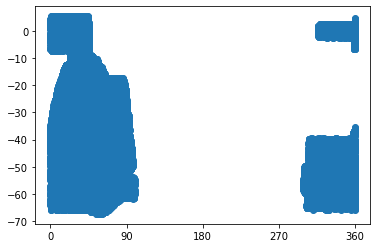

In [134]:
# plt.scatter(plsz2.pl_ra,plsz2.pl_dec)
plt.scatter(wh22.ra,wh22.dec)
plt.xticks([180,90,0,360,270])
# plt.scatter(amf_whl.amf_ra, amf_whl.amf_dec)

(array([10156., 18544., 21483., 22047., 16552., 16590., 14533.,  8288.,
         8428., 14623.]),
 array([-67.37904 , -60.104874, -52.830708, -45.556542, -38.282376,
        -31.00821 , -23.734044, -16.459878,  -9.185712,  -1.911546,
          5.36262 ]),
 <BarContainer object of 10 artists>)

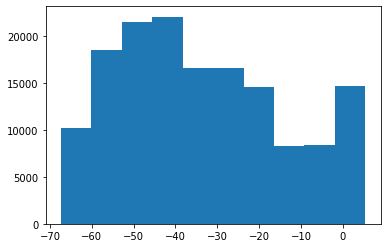

In [121]:
# plt.hist(plsz2.pl_dec)
plt.hist(wh22.dec)